## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Оглавление
1. [Подготовка](#One)
2. [Анализ](#Two)
3. [Обучение](#Three)
4. [Тестирование](#Four)
5. [Общий вывод](#Five)

# 1. Подготовка<a class="anchor" id="One"></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict , KFold

from sklearn.preprocessing import StandardScaler
import time

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#базовые библиотеки машинного обучения
from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

#игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Загрузим данные, делаем столбец datetime индексом, а также сделаем автопарсинг
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(ascending=True, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
# Проверка на монотоность
data.index.is_monotonic

True

In [9]:
#Выполняем ресемплирование
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


- Как видим у нас срез данных за полгода

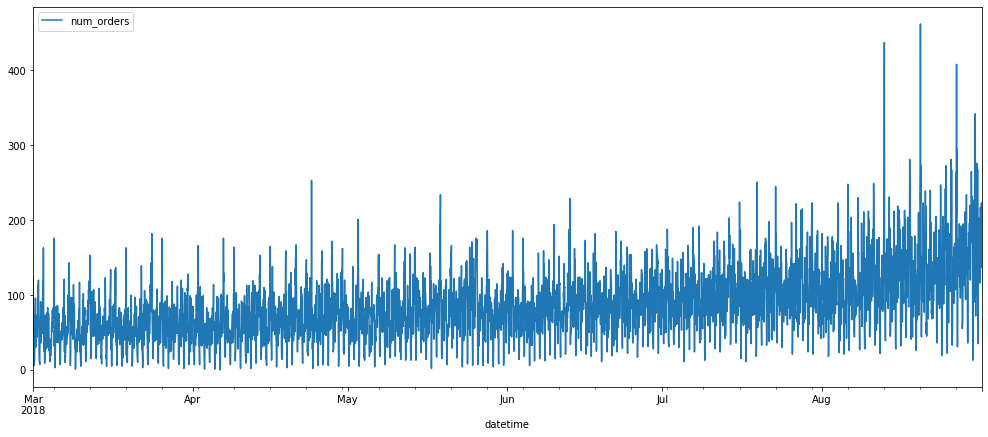

In [11]:
data.plot(figsize = (17, 7))

In [12]:
# Добавим признаки

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
      
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 14, 12)
data = data.dropna()
display(data.head())
data_copy = data.copy()

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,44.833333
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.916667
2018-03-01 16:00:00,43,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.916667
2018-03-01 17:00:00,44,3,1,3,17,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,42.916667
2018-03-01 18:00:00,73,3,1,3,18,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,46.083333


# 2. Анализ<a class="anchor" id="Two"></a>

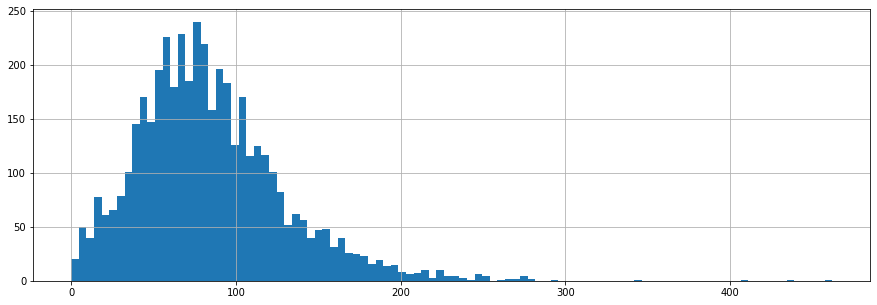

In [13]:
data['num_orders'].hist(bins = 100, figsize = (15, 5))

In [14]:
decomposed = seasonal_decompose(data['num_orders'])

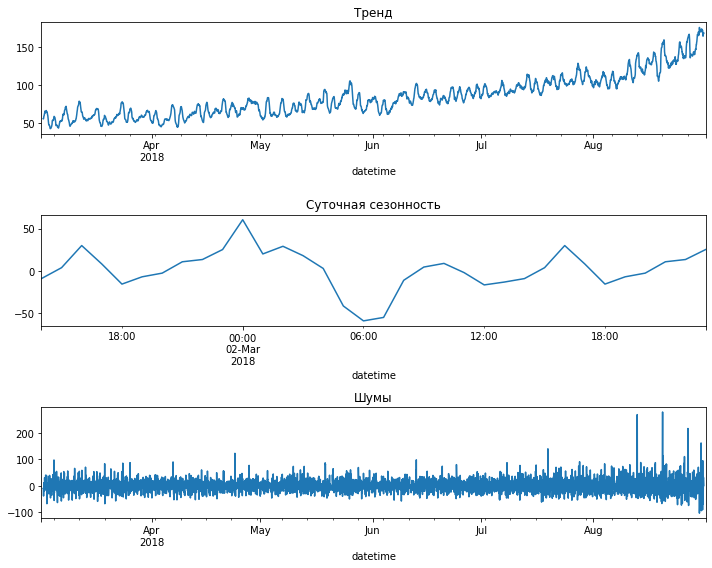

In [15]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

decomposed.seasonal = decomposed.seasonal['2018-03-01':'2018-03-02']
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Суточная сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')

plt.tight_layout()

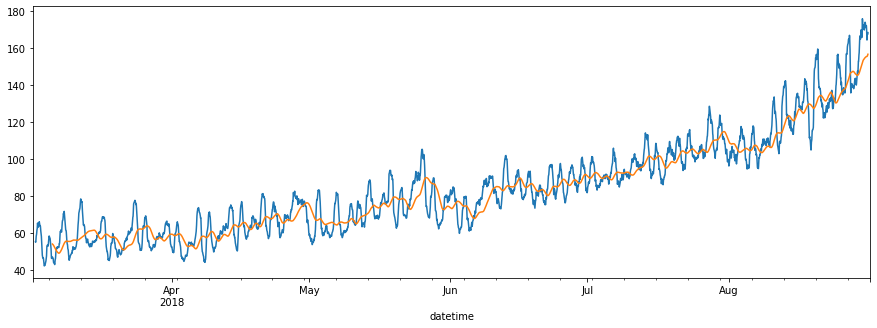

In [16]:
decomposed.trend.plot(figsize=(15,5))
decomposed.trend.rolling(90).mean().plot()


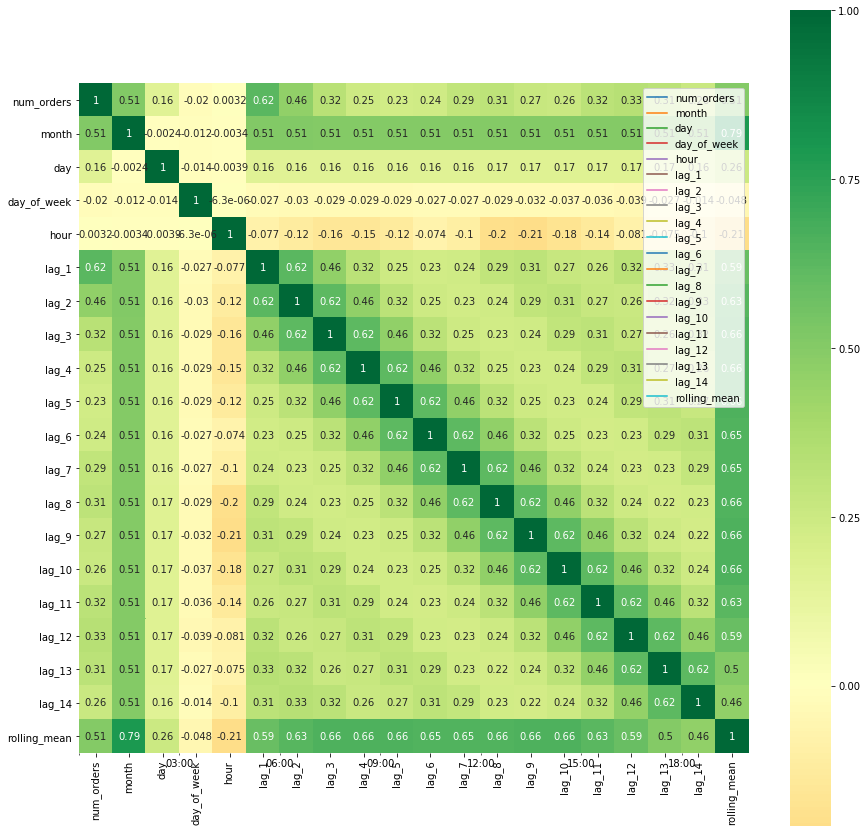

In [17]:
data.plot(figsize=(15,15))
sns.heatmap(data.corr(), cmap='RdYlGn', center=0, annot=True, square=True)

### Вывод

- Заданный процесс - стахостический нестационарный. 
- График тренда показывает увеличение количества заказов с марта по сентябрь в 3 раза.
- Сезонность - стационарна,связанна со временем суток, в который совершались заказы. Минимальное количество заказов приходится на 6 утра, максимум - в вечерние часы 22-23.
- Шумы практически стационарны, и нарастают к концу временного периода. Возможно это негативно скажется на результатах предсказаний, так как в тестовую выборку войдет как раз последние 10% датасета.

# 3. Обучение <a class="anchor" id="Three"></a>

In [18]:
# Разделим сет на выбоки
features = data_copy.drop(['num_orders'], axis=1)
target = data_copy['num_orders']

x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [19]:
# Масштабирование
scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns = x_train.columns)
x_test =  pd.DataFrame(data = scaler.transform(x_test), columns = x_train.columns)

### LinearRegression

In [20]:
%%time
start_time = time.time()

lr_model = LinearRegression()

# Значения метрики на кросс валидации
lr_cv_rmse = (cross_val_score(lr_model, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean()*-1)**0.5
print('Значение RMSE для LinearRegression на train =', lr_cv_rmse)

lr_cv_time = time.time() - start_time

Значение RMSE для LinearRegression на train = 30.5184314325269
CPU times: user 163 ms, sys: 277 ms, total: 441 ms
Wall time: 408 ms


### RandomForestRegressor

In [21]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor(random_state = 12345)

#Параметры для GridSearch
parametrs_grid = {'n_estimators': range(60, 100, 10),'max_depth' : range(10, 40, 10)}

grid_cv_rf = GridSearchCV(rf_model, parametrs_grid)
grid_cv_rf.fit(x_train, y_train)
print(grid_cv_rf.best_params_)

# Значения метрики на кросс валидации
rf_cv_rmse = (cross_val_score(rf_model , 
                            x_train, 
                            y_train , 
                            cv=5 , 
                            scoring='neg_mean_squared_error').mean()*-1)**0.5

print('Значение RMSE для Random Forest на train:' , rf_cv_rmse)

rf_cv_time = time.time() - start_time 


{'max_depth': 20, 'n_estimators': 60}
Значение RMSE для Random Forest на train: 25.761233869487477
CPU times: user 1min 12s, sys: 204 ms, total: 1min 12s
Wall time: 1min 13s


### XGBoost

In [22]:
%%time
start_time = time.time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', gpu_id=0, random_state = 12345)

hyperparametrs = { 'max_depth': [5, 7, 10],
                'n_estimators': [100, 200]}

grid_xgbst = GridSearchCV(xgb_model, hyperparametrs, scoring='neg_mean_squared_error', cv=5)
model_xgboost = grid_xgbst.fit(x_train, y_train)

print('Лучшие гиперпараметры:')
print()
print(grid_xgbst.best_params_)
print()

print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_xgbst.cv_results_['mean_test_score']
stds = grid_xgbst.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_xgbst.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()
xgboost_cv_rmse = (max(means)*-1) ** 0.5
xgboost_cv_time = time.time() - start_time # Записываем время работы ячейки

Лучшие гиперпараметры:

{'max_depth': 7, 'n_estimators': 100}

RMSE при разных значениях гиперпараметров:

24.2090 for {'max_depth': 5, 'n_estimators': 100}
24.1408 for {'max_depth': 5, 'n_estimators': 200}
24.0795 for {'max_depth': 7, 'n_estimators': 100}
24.1647 for {'max_depth': 7, 'n_estimators': 200}
24.9953 for {'max_depth': 10, 'n_estimators': 100}
25.0094 for {'max_depth': 10, 'n_estimators': 200}

CPU times: user 41.2 s, sys: 216 ms, total: 41.4 s
Wall time: 41.8 s


### LightGBM

In [23]:
%%time
start_time = time.time()

LGBM = LGBMRegressor(random_state=12345, learning_rate=0.1) 
hyperparams = [{'num_leaves':[100, 200], 
                'max_depth':[5,6,7],
                'min_data_in_leaf':[10, 20, 30]}]

grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_squared_error', cv=5)
grid_lgbm.fit(x_train, y_train)

print('Лучшие гиперпараметры:')
print()
print(grid_lgbm.best_params_)
print()
print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_lgbm.cv_results_['mean_test_score']
stds = grid_lgbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lgbm.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()

lgbm_cv_rmse = (max(means)*-1) ** 0.5
lgbm_cv_time = time.time() - start_time # Записываем время работы ячейки 

Лучшие гиперпараметры:

{'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 100}

RMSE при разных значениях гиперпараметров:

23.7076 for {'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 100}
23.7076 for {'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 200}
23.6553 for {'max_depth': 5, 'min_data_in_leaf': 20, 'num_leaves': 100}
23.6553 for {'max_depth': 5, 'min_data_in_leaf': 20, 'num_leaves': 200}
23.4994 for {'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 100}
23.4994 for {'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 200}
23.6869 for {'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 100}
23.6869 for {'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 200}
23.5725 for {'max_depth': 6, 'min_data_in_leaf': 20, 'num_leaves': 100}
23.5725 for {'max_depth': 6, 'min_data_in_leaf': 20, 'num_leaves': 200}
23.5035 for {'max_depth': 6, 'min_data_in_leaf': 30, 'num_leaves': 100}
23.5035 for {'max_depth': 6, 'min_data_in_leaf': 30, 'num_leaves': 200}
23.9031

### SGDRegressor

In [24]:
%%time
start_time = time.time()

sgd_model = SGDRegressor()

# Значения метрики на кросс валидации
sgd_cv_rmse = (cross_val_score(sgd_model, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean()*-1)**0.5
print('Значение RMSE для LinearRegression на train =', sgd_cv_rmse)

sgd_cv_time = time.time() - start_time

Значение RMSE для LinearRegression на train = 30.42083541723329
CPU times: user 306 ms, sys: 261 ms, total: 567 ms
Wall time: 570 ms


- Добавил признаки для обучения моделей:
    - час
    - день
    - день недели
    - месяц
    - отстающие значения
    - скользящее среднее
- Выбрал модели для обучения : LinearRegression, RandomForestRegressor, XGBoost, LightGBM, SGDRegressor


# 4. Тестирование<a class="anchor" id="Four"></a>

### LinearRegression

In [25]:
%%time
start_time = time.time()

lr_model.fit(x_train, y_train)
lr_rmse = mse(y_test, lr_model.predict(x_test))**0.5
print('Значение RMSE для LinearRegression на test =' , lr_rmse)

lr_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LinearRegression на test = 53.543832722167124
CPU times: user 17.7 ms, sys: 8.04 ms, total: 25.7 ms
Wall time: 7.56 ms


### RandomForestRegressor

In [26]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor( max_depth=30, n_estimators=90, random_state = 12345) 

# Модель на тестовой выборке

rf_model.fit(x_train, y_train)
rf_rmse = mse(y_test, rf_model.predict(x_test))**0.5
print('Значение RMSE для Random Forest на test:' , rf_rmse)

rf_time = time.time() - start_time # Записываем время работы ячейки 

Значение RMSE для Random Forest на test: 43.301248753796095
CPU times: user 3.68 s, sys: 56.1 ms, total: 3.73 s
Wall time: 3.81 s


Text(0.5, 0, 'Относительные значения')

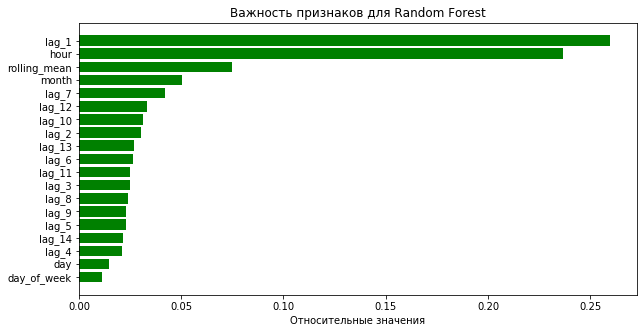

In [27]:
features=x_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

### XGBoost

In [28]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Модель на тестовой выборке
start_time = time.time()
xgb_test = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=5, n_estimators=200, gpu_id=0, random_state = 12345)

# Обучаем модель
xgb_test.fit(x_train, y_train)  
# Делаем предсказания
preds = xgb_test.predict(x_test)
xgboost_rmse = mse(y_test, preds)**0.5

print('Значение  RMSE для XGBoost на test:', xgboost_rmse)

xgboost_time = time.time() - start_time # Записываем время работы ячейки

Значение  RMSE для XGBoost на test: 43.48547550717097
CPU times: user 1.2 s, sys: 24.1 ms, total: 1.23 s
Wall time: 1.24 s


Text(0.5, 0, 'Относительные значения')

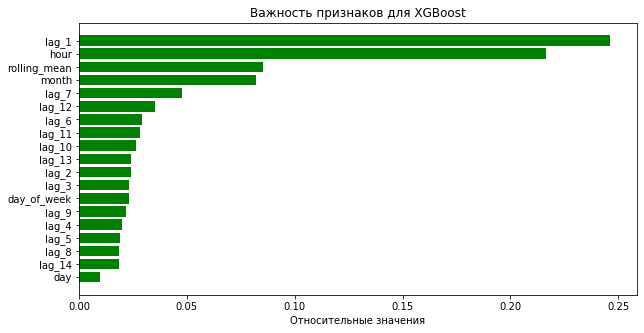

In [29]:
features = x_train.columns
importances = xgb_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для XGBoost')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

### LightGBM

In [30]:
%%time
# Модель на тестовой выборке
start_time = time.time()
LGBM_test = LGBMRegressor(random_state=12345, learning_rate=0.1, depth=6, min_data_in_leaf=20, num_leaves=100)

# Обучаем модель
LGBM_test.fit(x_train, y_train)  
# Делаем предсказания
preds = LGBM_test.predict(x_test)
lgbm_rmse = mse(y_test, preds)**0.5

print('Значение RMSE для LightGBM на test:', lgbm_rmse)

lgbm_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LightGBM на test: 42.27418029135545
CPU times: user 743 ms, sys: 20 ms, total: 763 ms
Wall time: 773 ms


Text(0.5, 0, 'Относительные значения')

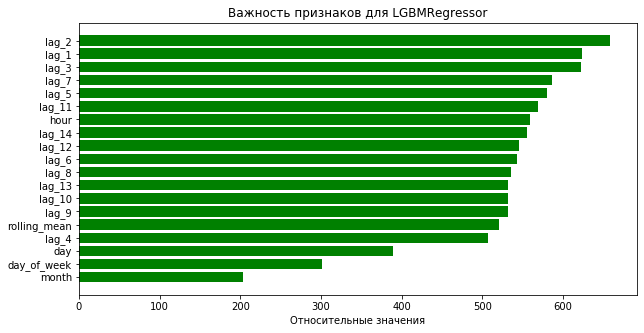

In [31]:
features = x_train.columns
importances = LGBM_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для LGBMRegressor')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

### SGDRegressor

In [33]:
%%time
start_time = time.time()
sgd_model = SGDRegressor()
sgd_model.fit(x_train, y_train)
predict_sgd_model = sgd_model.predict(x_test)
sgd_rmse = mse(y_test, predict_sgd_model)**(0.5)

print('Значение RMSE для SGD на test:', sgd_rmse)
sgd_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для SGD на test: 51.516633337298586
CPU times: user 16.3 ms, sys: 77 µs, total: 16.4 ms
Wall time: 14.3 ms


In [34]:
# Записываем результаты в словарь
dict_results = {'Model': ['LinearRegression,' , 'Random_Forest' , 'LightGBM' ,'XGBoost', 'SDG'],
               'RMSE_CV':[lr_cv_rmse , rf_cv_rmse , lgbm_cv_rmse , xgboost_cv_rmse, sgd_cv_rmse] ,
               'RMSE_test': [lr_rmse , rf_rmse , lgbm_rmse , xgboost_rmse, sgd_rmse] , 
               'Working_time_CV' : [lr_cv_time , rf_cv_time , lgbm_cv_time , xgboost_cv_time, sgd_cv_time ],
               'Working_time_test': [lr_time , rf_time , lgbm_time , xgboost_time, sgd_time]
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,RMSE_CV,RMSE_test,Working_time_CV,Working_time_test
0,"LinearRegression,",30.518431,53.543833,0.407530,0.007534
1,Random_Forest,25.761234,43.301249,73.417279,3.813126
2,LightGBM,23.499448,42.274180,22.406932,0.773358
3,XGBoost,24.079511,43.485476,41.760663,1.237166
4,SDG,30.420835,51.516633,0.570073,0.014314


### Вывод

- В результатате тестирования лучший RMSE у LightGBM. По скорости тоже одна из самых быстрвх моделей.
- Далее идут модели RandomForest и XGBoost.

# 5. Общий вывод<a class="anchor" id="Five"></a>

В ходе работы над проектом:

- были загружены данные из файла, изучены, ресемплированы по одному часу.
- данные проанализированы: изучены тренды и сезонность.
- добавлены новые календарные признаки, отстающие значения, рассчитано скользящее среднее
- данные разделены на обучающую и тестовую выборки.
- обучено несколько моделей с разными гипермпараметрами
- модели проверена на тестовой выборке
- по RMSE выбрана лучшая - LightGBM, результат удовлетворительный RMSE = 42.27


# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48